In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

## Reformat Data

In [2]:
import os
import shutil

def process_data_folder(data_path, folder_name):
    """
    Processes the given folder (train or val) to:
    - Copy and rename images.
    - Copy and rename labels.
    - Create empty label files if missing.

    Arguments:
    - data_path: Base path containing 'train' and 'val' folders.
    - folder_name: Name of the folder to process ('train' or 'val').
    """
    folder_path = os.path.join(data_path, folder_name)
    output_path = os.path.join("/kaggle/working/", folder_name)
    images_output = os.path.join(output_path, 'images')
    labels_output = os.path.join(output_path, 'labels')
    os.makedirs(images_output, exist_ok=True)
    os.makedirs(labels_output, exist_ok=True)

    images_folder = os.path.join(folder_path, 'images')
    detections_folder = os.path.join(folder_path, 'detections')

    for subject in os.listdir(images_folder):
        subject_images_path = os.path.join(images_folder, subject)
        subject_detections_path = os.path.join(detections_folder, subject)

        if not os.path.isdir(subject_images_path):
            continue

        for image_name in os.listdir(subject_images_path):
            image_path = os.path.join(subject_images_path, image_name)
            image_id = os.path.splitext(image_name)[0]

            new_image_name = f"{subject}_{image_id}.png"
            new_image_path = os.path.join(images_output, new_image_name)

            shutil.copy(image_path, new_image_path)

            label_file = os.path.join(subject_detections_path, f"{image_id}.txt")
            new_label_name = f"{subject}_{image_id}.txt"
            new_label_path = os.path.join(labels_output, new_label_name)

            if os.path.exists(label_file):
                with open(label_file, 'r') as f:
                    labels = f.readlines()

                if labels:
                    with open(new_label_path, 'w') as f:
                        f.writelines(labels)
                else:
                    print(f"Warning: The label file for {image_name} is empty. Creating empty label.")
                    open(new_label_path, 'w').close()
            else:
                open(new_label_path, 'w').close()
                print(f"Warning: No label file found for {image_name}. Creating empty label.")

    print(f"Processing of {folder_name} complete. Images saved in {images_output}, labels saved in {labels_output}.")

data_path = "/kaggle/input/computer-vision-project"
process_data_folder(data_path, 'train')
process_data_folder(data_path, 'val')

Processing of train complete. Images saved in /kaggle/working/train/images, labels saved in /kaggle/working/train/labels.
Processing of val complete. Images saved in /kaggle/working/val/images, labels saved in /kaggle/working/val/labels.


## Construct Coco Dataset

In [3]:
from PIL import Image
import json

def convert_to_coco(input_dir, output_file):
    # Define COCO format structure
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "tumor"}],  # Categories in your dataset
    }

    image_id = 0
    annotation_id = 0

    # Traverse your dataset and convert images and annotations to COCO format
    images_dir = os.path.join(input_dir, 'images')
    labels_dir = os.path.join(input_dir, 'labels')

    for image_name in os.listdir(images_dir):
        if not image_name.endswith('.png'):
            continue

        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(labels_dir, image_name.replace(".png", ".txt"))

        # Read the image
        img = Image.open(image_path)
        width, height = img.size

        # Add image info to coco_format
        image_id += 1
        coco_format["images"].append({
            "id": image_id,
            "file_name": image_name,
            "width": width,
            "height": height
        })

        # Read annotations (if any) and add them to the COCO annotations list
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            if len(lines) > 0:
                for line in lines:
                    # Parse bounding box coordinates (xmin, ymin, xmax, ymax)
                    xmin, ymin, xmax, ymax = map(float, line.strip().split(','))

                    # COCO format uses the format [xmin, ymin, width, height] for bounding boxes
                    width = xmax - xmin
                    height = ymax - ymin

                    annotation_id += 1
                    coco_format["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": 1,  # 'tumor' class
                        "bbox": [xmin, ymin, width, height],
                        "area": width * height,
                        "iscrowd": 0
                    })
            else:
                # If the label file is empty, still create an entry with no bounding box
                coco_format["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 0,  # 'tumor' class
                    "bbox": [0, 0, 0, 0],  # No tumor, empty bbox
                    "area": 0,
                    "iscrowd": 0
                })

    # Save the COCO annotation to a JSON file
    with open(output_file, 'w') as json_file:
        json.dump(coco_format, json_file)

In [4]:
# For the train dataset
input_dir = "/kaggle/working/train"  # Your dataset path after processing
output_file_train = "coco_annotations_train.json"  # Output JSON file for COCO format (train dataset)
convert_to_coco(input_dir, output_file_train)

# For the val dataset
input_dir = "/kaggle/working/val"  # Your dataset path after processing
output_file_val = "coco_annotations_val.json"  # Output JSON file for COCO format (val dataset)
convert_to_coco(input_dir, output_file_val)


In [5]:
import json

# Load the COCO annotations JSON file
with open('coco_annotations_val.json', 'r') as f:
    coco_data = json.load(f)

# Print the structure of the JSON file
print(json.dumps(coco_data, indent=4))  # Pretty print the JSON with indentation

# Check if it contains 'images', 'annotations', and 'categories'
print(f"Images: {len(coco_data['images'])}")
print(f"Annotations: {len(coco_data['annotations'])}")
print(f"Categories: {len(coco_data['categories'])}")


{
    "images": [
        {
            "id": 1,
            "file_name": "Subject_59_1.png",
            "width": 256,
            "height": 256
        },
        {
            "id": 2,
            "file_name": "Subject_59_90.png",
            "width": 256,
            "height": 256
        },
        {
            "id": 3,
            "file_name": "Subject_58_303.png",
            "width": 256,
            "height": 256
        },
        {
            "id": 4,
            "file_name": "Subject_58_290.png",
            "width": 256,
            "height": 256
        },
        {
            "id": 5,
            "file_name": "Subject_59_85.png",
            "width": 256,
            "height": 256
        },
        {
            "id": 6,
            "file_name": "Subject_60_49.png",
            "width": 256,
            "height": 256
        },
        {
            "id": 7,
            "file_name": "Subject_60_52.png",
            "width": 256,
            "height": 256
        },
 

In [6]:
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

In [7]:
# !pip install --upgrade pip

In [8]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 11.7 MB/s eta 0:00:0000:01


## Configurations

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Used device {device}")
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)
torch.set_float32_matmul_precision('high')
torch.cuda.empty_cache()
batch_size = 16
image_size= 256

Used device cuda


## Modeling

In [10]:
class CocoTransform:
  def __call__(self , image , target) :
    image = F.to_tensor(image)
    return image , target

In [11]:
def get_coco_dataset(img_dir,ann_file):
  return CocoDetection(
      root = img_dir ,
      annFile = ann_file ,
      transforms=CocoTransform())

train_dataset= get_coco_dataset(
    img_dir="/kaggle/working/train/images",
    ann_file="/kaggle/working/coco_annotations_train.json"
)

val_dataset= get_coco_dataset(
    img_dir="/kaggle/working/val/images",
    ann_file="/kaggle/working/coco_annotations_val.json"
)

train_loader = DataLoader(train_dataset , batch_size=batch_size , shuffle=True , collate_fn=lambda x: tuple(zip(*x)),num_workers=os.cpu_count(),pin_memory=True)
val_loader = DataLoader(val_dataset , batch_size=batch_size , shuffle=False , collate_fn=lambda x: tuple(zip(*x)),num_workers=os.cpu_count(),pin_memory=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
for x, y in train_loader:
    print(f"Batch image shape: {len(x)}, Batch mask shape: {len(y)}")
    break

Batch image shape: 16, Batch mask shape: 16


In [13]:
def get_model(num_classes):

  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

## Training

In [14]:
num_classes = 2
model = get_model(num_classes)
model.to(device)
EPOCHS = 20
lr=0.01
weight_decay = 0.0005
optimizer = torch.optim.SGD(model.parameters(),lr=lr,fused=True,weight_decay=weight_decay,momentum=0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 232MB/s] 


In [15]:
model_dir = 'model'
log_dir = 'log'
os.makedirs(log_dir,exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir,f'log.txt')
with open(log_file,'w') as f:
    f.write(f"Epochs {EPOCHS} | learning_rate {lr} | weight_decay {weight_decay}| optimizer {optimizer.__class__.__name__}| loss function Faster RCNN Loss | Batch size {batch_size}| Image size {image_size}\n")

In [16]:


# optimizer = torch.optim.SGD(params, lr=0.001 , momentum=0.9 , weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
def validate(model, val_loader, device):
  # model.eval()
  val_loss = 0
  with torch.no_grad():
    for images, targets in val_loader:
      images = list(image.to(device) for image in images)
      processed_targets = []
      valid_images = []
      for i, target in enumerate(targets):
        boxes = []
        labels = []
        # Process the targets and extract bounding boxes and labels
        for obj in target:
          boxx = obj['bbox']
          x, y, w, h = boxx
          # Check if bounding box is valid
          if w > 0 and h > 0:
            boxes.append([x, y, x + w, y + h])
            labels.append(obj['category_id'])
        # If valid boxes are found, add to processed_targets
        if boxes:
          processed_targets.append({
              'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
              'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                  })
          valid_images.append(images[i])

      loss_dict = model(valid_images, processed_targets)
      losses = sum(loss for loss in loss_dict.values())
      val_loss += losses

  val_loss /= len(val_loader)

  return val_loss


In [18]:
total_train_loss = []
total_val_loss = []
best_val = 100

for epoch in range(EPOCHS):
  model.train()
  epoch_loss = 0
  for images, targets in tqdm(train_loader,desc=f'Epoch {epoch+1}/{EPOCHS}'):
    optimizer.zero_grad()
    # Move images to the target device (GPU/CPU)
    images = list(image.to(device) for image in images)

    processed_targets = []
    valid_images = []
    for i, target in enumerate(targets):
      boxes = []
      labels = []
      # Process the targets and extract bounding boxes and labels
      for obj in target:
        boxx = obj['bbox']
        x, y, w, h = boxx
        # Check if bounding box is valid
        if w > 0 and h > 0:
          boxes.append([x, y, x + w, y + h])
          labels.append(obj['category_id'])
      # If valid boxes are found, add to processed_targets
      if boxes:
        processed_targets.append({
            'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
            'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                })
        valid_images.append(images[i])

    if not processed_targets:
          continue

    loss_dict = model(valid_images, processed_targets)
    losses = sum(loss for loss in loss_dict.values() if loss_dict)
    losses.backward()
    optimizer.step()

    epoch_loss+= losses

  val_loss = validate(model, val_loader, device)
  epoch_loss/=len(train_loader)
  total_train_loss.append(epoch_loss)
  total_val_loss.append(val_loss)
  current_lr = optimizer.param_groups[0]['lr']
  lr_scheduler.step()

  if val_loss < best_val:
    print(f'Achieved Better Val with {val_loss}, Than {best_val}')
    best_val = val_loss
    torch.save(model.state_dict(),os.path.join(model_dir,"Faster_RCNN_weights.pth"))
  print(f"Epoch {epoch+1}| Train_loss: {epoch_loss:.4f}| Validate_loss: {val_loss:.4f}| Best Val {best_val:.4f}| lr {current_lr}")
  with open(log_file,'a') as f:
    f.write(f"Epoch {epoch+1}| Train_loss: {epoch_loss:.4f}| Validate_loss: {val_loss:.4f}| Best Val {best_val:.4f}| lr {current_lr}\n")

Epoch 1/20: 100%|██████████| 115/115 [02:28<00:00,  1.29s/it]


Achieved Better Val with 0.36222437024116516, Than 100
Epoch 1| Train_loss: 0.3298| Validate_loss: 0.3622| Best Val 0.3622| lr 0.0100


Epoch 2/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Achieved Better Val with 0.3609544038772583, Than 0.36222437024116516
Epoch 2| Train_loss: 0.2551| Validate_loss: 0.3610| Best Val 0.3610| lr 0.0100


Epoch 3/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 3| Train_loss: 0.2157| Validate_loss: 0.3779| Best Val 0.3610| lr 0.0100


Epoch 4/20: 100%|██████████| 115/115 [02:28<00:00,  1.29s/it]


Epoch 4| Train_loss: 0.1870| Validate_loss: 0.4113| Best Val 0.3610| lr 0.0010


Epoch 5/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 5| Train_loss: 0.1797| Validate_loss: 0.4239| Best Val 0.3610| lr 0.0010


Epoch 6/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 6| Train_loss: 0.1788| Validate_loss: 0.4315| Best Val 0.3610| lr 0.0010


Epoch 7/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 7| Train_loss: 0.1757| Validate_loss: 0.4351| Best Val 0.3610| lr 0.0001


Epoch 8/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 8| Train_loss: 0.1760| Validate_loss: 0.4383| Best Val 0.3610| lr 0.0001


Epoch 9/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 9| Train_loss: 0.1754| Validate_loss: 0.4415| Best Val 0.3610| lr 0.0001


Epoch 10/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 10| Train_loss: 0.1757| Validate_loss: 0.4368| Best Val 0.3610| lr 0.0000


Epoch 11/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 11| Train_loss: 0.1747| Validate_loss: 0.4380| Best Val 0.3610| lr 0.0000


Epoch 12/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 12| Train_loss: 0.1751| Validate_loss: 0.4384| Best Val 0.3610| lr 0.0000


Epoch 13/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 13| Train_loss: 0.1753| Validate_loss: 0.4371| Best Val 0.3610| lr 0.0000


Epoch 14/20: 100%|██████████| 115/115 [02:27<00:00,  1.29s/it]


Epoch 14| Train_loss: 0.1756| Validate_loss: 0.4391| Best Val 0.3610| lr 0.0000


Epoch 15/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 15| Train_loss: 0.1765| Validate_loss: 0.4372| Best Val 0.3610| lr 0.0000


Epoch 16/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 16| Train_loss: 0.1759| Validate_loss: 0.4433| Best Val 0.3610| lr 0.0000


Epoch 17/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 17| Train_loss: 0.1742| Validate_loss: 0.4380| Best Val 0.3610| lr 0.0000


Epoch 18/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 18| Train_loss: 0.1756| Validate_loss: 0.4411| Best Val 0.3610| lr 0.0000


Epoch 19/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 19| Train_loss: 0.1758| Validate_loss: 0.4382| Best Val 0.3610| lr 0.0000


Epoch 20/20: 100%|██████████| 115/115 [02:27<00:00,  1.28s/it]


Epoch 20| Train_loss: 0.1766| Validate_loss: 0.4361| Best Val 0.3610| lr 0.0000


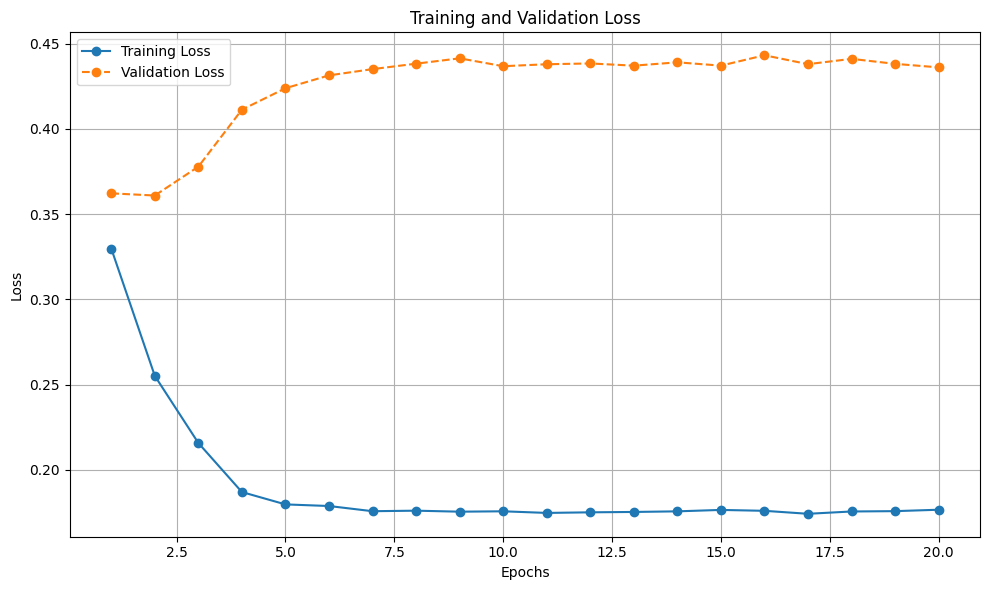

In [21]:
total_train_loss = [t.detach().numpy() for t in total_train_loss]
total_val_loss = [t.detach().numpy() for t in total_val_loss]

plt.figure(figsize=(10, 6))
epochs = range(1, len(total_train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, total_train_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, total_val_loss, label='Validation Loss', marker='o', linestyle='--')

# Add titles and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.savefig("loss_plot.png")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# import torch

# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.train()

#     for images, targets in data_loader:
#         # Move images to the target device (GPU/CPU)
#         images = [img.to(device) for img in images]

#         processed_targets = []
#         valid_images = []

#         for i, target in enumerate(targets):
#             boxes = []
#             labels = []

#             # Process the targets and extract bounding boxes and labels
#             for obj in target:
#                 boxx = obj['bbox']
#                 x, y, w, h = boxx

#                 # Check if bounding box is valid
#                 if w > 0 and h > 0:
#                     boxes.append([x, y, x + w, y + h])
#                     labels.append(obj['category_id'])

#             # If valid boxes are found, add to processed_targets
#             if boxes:
#                 processed_targets.append({
#                     'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
#                     'labels': torch.tensor(labels, dtype=torch.int64).to(device)
#                 })
#                 valid_images.append(images[i])

#         # If no valid targets, skip this batch
#         if not processed_targets:
#             continue

#         # Now we have valid images and targets
#         loss_dict = model(valid_images, processed_targets)
#         losses = sum(loss for loss in loss_dict.values())

#         # Backpropagation and optimization step
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item():.4f}")

# # Number of epochs
# num_epochs = 10
# for epoch in range(num_epochs):
#     train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

#     model_path = f"model_epoch_{epoch+1}.pth"
#     torch.save(model.state_dict(), model_path)
#     print(f"Model saved at {model_path}")


In [ ]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

#     model_path = f"model_epoch_{epoch+1}.pth"
#     torch.save(model.state_dict(), model_path)
#     print(f"Model saved at {model_path}")

In [ ]:
# model = get_model(num_classes)
# model.load_state_dict(torch.load('/content/model_epoch_10.pth'))
# model.to(device)
# model.eval()

# def prepare_image(image):
#     image = Image.open(image)
#     image_tensor = F.to_tensor(image).unsqueeze(0)
#     return image_tensor.to(device)

# image_path ="/content/dataset/val/images/Subject_58_101.png"
# image_tensor=prepare_image(image_path)

# with torch.no_grad():
#   prediction = model(image_tensor)

# COCO_CLASSES = {0:"Background" , 1:"tumor"}

# def get_class_name(class_id):
#   return COCO_CLASSES.get(class_id, "Unknown")

# def draw_boxes( image , prediction , fig_size=(10,10)):
#   boxes=prediction[0]['boxes'].cpu().numpy()
#   labels=prediction[0]['labels'].cpu().numpy()
#   scores=prediction[0]['scores'].cpu().numpy()

#   threshold=0.5

#   plt.figure(figsize=fig_size)

#   for box , label , score in zip(boxes , labels , scores):
#     if score > threshold:
#       x_min , y_min , x_max , y_max = box
#       class_name=get_class_name(label)
#       plt.imshow(image)
#       plt.gca().add_patch(plt.Rectangle((x_min,y_min),x_max - x_min , y_max-y_min, linewidth=2 , edgecolor='r',facecolor='none'))

#       plt.text(x_min,y_min,f"{class_name} ({score:.2f})", color ='y')

#     plt.axis("off")
#     plt.show()

# draw_boxes(Image.open(image_path),prediction,fig_size=(12,10))

In [ ]:
# import matplotlib.pyplot as plt
# import torch
# from PIL import Image
# import torchvision.transforms.functional as F

# COCO_CLASSES = {0: "Background", 1: "tumor"}

# def get_class_name(class_id):
#     return COCO_CLASSES.get(class_id, "Unknown")

# def draw_boxes(image, prediction, fig_size=(10, 10)):
#     if image.mode != 'L':
#         image = image.convert("L")

#     boxes = prediction[0]['boxes'].cpu().numpy()
#     labels = prediction[0]['labels'].cpu().numpy()
#     scores = prediction[0]['scores'].cpu().numpy()

#     threshold = 0.5
#     print(f"Prediction scores: {scores}")

#     plt.figure(figsize=fig_size)

#     for box, label, score in zip(boxes, labels, scores):
#         if score > threshold:
#             x_min, y_min, x_max, y_max = box
#             class_name = get_class_name(label)
#             plt.imshow(image, cmap='gray')  # Display the image in grayscale
#             plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                                               linewidth=2, edgecolor='r', facecolor='none'))
#             plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='y')

#     plt.axis("off")
#     plt.show()

# # Example usage
# image_path = "/content/dataset/val/images/Subject_57_202.png"
# image_tensor = prepare_image(image_path)

# with torch.no_grad():
#     prediction = model(image_tensor)

# draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))


In [ ]:
# import matplotlib.pyplot as plt
# import torch
# from PIL import Image
# import torchvision.transforms.functional as F

# COCO_CLASSES = {0: "Background", 1: "tumor"}

# def get_class_name(class_id):
#     return COCO_CLASSES.get(class_id, "Unknown")

# def draw_boxes(image, prediction, fig_size=(10, 10)):
#     if image.mode != 'L':
#         image = image.convert("L")

#     boxes = prediction[0]['boxes'].cpu().numpy()
#     labels = prediction[0]['labels'].cpu().numpy()
#     scores = prediction[0]['scores'].cpu().numpy()

#     threshold = 0.5
#     print(f"Prediction scores: {scores}")

#     plt.figure(figsize=fig_size)
#     plt.imshow(image, cmap='gray')  # Always display the image in grayscale

#     # If there are no predictions, just show the image without any boxes
#     if len(boxes) == 0:
#         plt.axis("off")
#         plt.show()
#         return

#     # Draw bounding boxes and labels if predictions exist
#     for box, label, score in zip(boxes, labels, scores):
#         if score > threshold:
#             x_min, y_min, x_max, y_max = box
#             class_name = get_class_name(label)
#             plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                                               linewidth=2, edgecolor='r', facecolor='none'))
#             plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='y')

#     plt.axis("off")
#     plt.show()

# # Example usage
# image_path = "/content/dataset/val/images/Subject_58_101.png"
# image_tensor = prepare_image(image_path)

# with torch.no_grad():
#     prediction = model(image_tensor)

# draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))
